# Yape architecture simulation: monolith vs. cell-based write-path

This notebook orchestrates a discrete-event simulation (DES) comparing a
synchronous monolithic write-path against an asynchronous, sharded cell-based
ingestion pattern under configurable traffic conditions.

**Outputs:** publication-ready figures (PNG, 300 dpi) and summary-statistics
tables suitable for direct inclusion in an academic manuscript.

**Reproducibility:** all experiment parameters are defined in a single
`ExperimentConfig` dataclass — no tunable values are hard-coded in the
simulation engine.  The random seed guarantees bitwise-identical results
across environments.

**Author:** Carlos Ulisses Flores

**Repository:** [mit507-yape-architecture-sim](https://github.com/ulissesflores/mit507-yape-architecture-sim)  
**DOI:** [10.5281/zenodo.18641336](https://doi.org/10.5281/zenodo.18641336)


## 1 &ensp; Environment bootstrap

Clone the repository (if running on Colab) and install **only** the packages
that Colab does not ship (currently just `simpy`).  The scientific stack
(`numpy`, `pandas`, `matplotlib`, `seaborn`) is left untouched to avoid
ABI-incompatible binary reinstallation — the root cause of the
`numpy.dtype size changed` crash on Colab kernels.

For local execution, `pip install -r requirements.txt` installs exact pins.


In [1]:
"""Environment bootstrap — Colab-safe, no kernel restart required."""

from __future__ import annotations

import subprocess
import sys
from pathlib import Path


REPO_URL: str = "https://github.com/ulissesflores/mit507-yape-architecture-sim.git"
REPO_DIR: Path = Path("mit507-yape-architecture-sim")


def _is_colab() -> bool:
    try:
        import google.colab  # type: ignore[import-untyped]  # noqa: F401
        return True
    except Exception:
        return False


def _find_project_root(start: Path) -> Path | None:
    """Walk upward until a directory containing src/simulation.py is found."""
    for p in [start, *start.parents]:
        if (p / "src" / "simulation.py").exists():
            return p
    return None


def bootstrap() -> Path:
    """Resolve project root, install only missing packages, return root path.

    Design rationale
    ----------------
    Colab ships pre-compiled numpy >= 2.x, pandas, matplotlib, and seaborn.
    Force-reinstalling older pinned versions (e.g. numpy 1.26.4) over live
    Cython extensions causes an irrecoverable ABI mismatch:
        ``ValueError: numpy.dtype size changed``

    This bootstrap therefore installs **only** packages absent from the
    runtime (currently ``simpy``).  No kernel restart is triggered.

    For fully pinned local reproducibility, use:
        ``pip install -r requirements.txt``
    """
    root = _find_project_root(Path.cwd())
    if root is None:
        if not REPO_DIR.exists():
            print(f"Cloning {REPO_URL} ...")
            subprocess.run(
                ["git", "clone", "--depth", "1", REPO_URL, str(REPO_DIR)],
                check=True,
            )
        root = REPO_DIR.resolve()

    src_dir = root / "src"
    src_dir.mkdir(parents=True, exist_ok=True)
    (src_dir / "__init__.py").touch(exist_ok=True)

    missing: list[str] = []
    try:
        import simpy  # noqa: F401
    except ImportError:
        missing.append("simpy")

    if missing:
        print(f"Installing missing packages: {missing}")
        subprocess.run(
            [sys.executable, "-m", "pip", "install", "--quiet", *missing],
            check=True,
        )

    if str(root) not in sys.path:
        sys.path.insert(0, str(root))

    print(f"Project root: {root}")
    return root


PROJECT_ROOT = bootstrap()


Cloning https://github.com/ulissesflores/mit507-yape-architecture-sim.git ...
Installing missing packages: ['simpy']
Project root: /content/mit507-yape-architecture-sim


## 2 &ensp; Imports and plot configuration


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from src.simulation import ExperimentConfig, run_simulation

# Publication-quality plot defaults.
sns.set_theme(style="whitegrid", context="paper")
plt.rcParams.update(
    {
        "figure.dpi": 150,
        "savefig.dpi": 300,
        "axes.titlesize": 12,
        "figure.titlesize": 14,
    }
)

print(
    f"numpy {np.__version__}  |  pandas {pd.__version__}  |  "
    f"ExperimentConfig fields: {len(ExperimentConfig.__dataclass_fields__)}"
)


numpy 2.0.2  |  pandas 2.2.2  |  ExperimentConfig fields: 22


## 3 &ensp; Experiment configuration

All tunable parameters are declared here — **not** inside the simulation
engine.  This separation follows the configuration-as-data principle:
changing experimental conditions never requires modifying source code.

The `ExperimentConfig` dataclass is frozen (immutable) and validates
invariants at construction time.


In [3]:
# --------------------------------------------------------------------------
# Experiment parameters (edit ONLY this cell to vary conditions)
# --------------------------------------------------------------------------

# Aggregation window used for throughput (Fig. 4).
THROUGHPUT_BIN_MS = 500  # ms

SHARED_PARAMS = dict(
    random_seed=42,
    simulation_time=30_000,          # horizon (ms)
    arrival_rate_normal=50,          # transactions / second
    arrival_rate_stress=2000,        # transactions / second
    event_bus_ack_ms=2.0,            # baseline async ingress ACK (ms)
    num_cells=10,                    # cell-based shards
    db_pool_capacity=50,             # monolith connection-pool slots
    cell_capacity=10,                # per-cell worker capacity
    contention_queue_threshold=20,   # monolith degradation trigger
    contention_penalty_factor=5.0,   # service-time multiplier
    latency_log_mean_ms=50.0,        # log-normal location (ms)
    latency_log_sigma=0.5,           # log-normal scale
    shard_id_upper_bound=10_000,     # uniform shard-key space
)

# ACK variability model (CELL_BASED only).
# These parameters are explicitly designed to be:
# (i) lightweight (no extra dependencies),
# (ii) reproducible (seeded RNG),
# (iii) empirically plausible (micro-jitter + rare tail spikes),
# (iv) configurable from this notebook cell (no hard-coded magic numbers).
ACK_JITTER_PARAMS = dict(
    event_bus_ack_jitter_lognorm_sigma=0.25,   # multiplicative jitter (mean 1.0)
    event_bus_ack_additive_std_ms=0.30,        # additive micro-jitter (ms)
    event_bus_ack_backlog_scale_ms=0.01,       # backlog sensitivity (ms per queued req)
    event_bus_ack_tail_prob=0.003,             # rare tail event probability
    event_bus_ack_tail_lognorm_mu=float(np.log(30.0)),  # tail spike location (log-ms)
    event_bus_ack_tail_lognorm_sigma=0.80,     # tail spike scale (log-ms)
    event_bus_ack_floor_ms=0.10,               # physical lower bound (ms)
)

# Two experimental conditions: same traffic profile, different architectures.
cfg_monolith = ExperimentConfig(mode="MONOLITH",   traffic_type="STRESS", **SHARED_PARAMS)
cfg_cells    = ExperimentConfig(mode="CELL_BASED", traffic_type="STRESS", **SHARED_PARAMS, **ACK_JITTER_PARAMS)

print("Monolith config:", cfg_monolith.to_dict())
print()
print("Cell-based config:", cfg_cells.to_dict())


Monolith config: {'mode': 'MONOLITH', 'traffic_type': 'STRESS', 'random_seed': 42, 'simulation_time': 30000, 'arrival_rate_normal': 50, 'arrival_rate_stress': 2000, 'event_bus_ack_ms': 2.0, 'event_bus_ack_jitter_lognorm_sigma': 0.0, 'event_bus_ack_additive_std_ms': 0.0, 'event_bus_ack_backlog_scale_ms': 0.0, 'event_bus_ack_tail_prob': 0.0, 'event_bus_ack_tail_lognorm_mu': 0.0, 'event_bus_ack_tail_lognorm_sigma': 0.0, 'event_bus_ack_floor_ms': 0.1, 'num_cells': 10, 'db_pool_capacity': 50, 'cell_capacity': 10, 'contention_queue_threshold': 20, 'contention_penalty_factor': 5.0, 'latency_log_mean_ms': 50.0, 'latency_log_sigma': 0.5, 'shard_id_upper_bound': 10000}

Cell-based config: {'mode': 'CELL_BASED', 'traffic_type': 'STRESS', 'random_seed': 42, 'simulation_time': 30000, 'arrival_rate_normal': 50, 'arrival_rate_stress': 2000, 'event_bus_ack_ms': 2.0, 'event_bus_ack_jitter_lognorm_sigma': 0.25, 'event_bus_ack_additive_std_ms': 0.3, 'event_bus_ack_backlog_scale_ms': 0.01, 'event_bus_ack_

## 4 &ensp; Experiment execution

Both scenarios are executed under identical stress traffic.  The simulation
engine is deterministic given the random seed.


In [4]:
df_monolith = run_simulation(config=cfg_monolith, verbose=True)
df_monolith["Scenario"] = "Monolith"

df_cells = run_simulation(config=cfg_cells, verbose=True)
df_cells["Scenario"] = "Cell-based"

# Consolidated log with derived time bins (used for throughput aggregation).
df = pd.concat([df_monolith, df_cells], ignore_index=True)
df["time_bin"] = (df["arrival_time"] // THROUGHPUT_BIN_MS).astype(int) * THROUGHPUT_BIN_MS

# Persist synthetic logs for downstream reproducibility.
df.to_csv("yape_synthetic_logs.csv", index=False)

print(f"Total transactions logged: {len(df):,}")
df.head()


[simulation] mode=MONOLITH  traffic=STRESS  rate=2000 tps  horizon=30000 ms  seed=42
[simulation] mode=CELL_BASED  traffic=STRESS  rate=2000 tps  horizon=30000 ms  seed=42
Total transactions logged: 65,769


,tx_id,architecture,arrival_time,wait_time,service_time,total_time,queue_size,cell_id,Scenario,time_bin
0,14,MONOLITH,4.823547,0.0,19.209076,19.209076,3,-1,Monolith,0
1,15,MONOLITH,6.399308,0.0,21.106142,21.106142,9,-1,Monolith,0
2,20,MONOLITH,7.687739,0.0,24.676988,24.676988,14,-1,Monolith,0
3,38,MONOLITH,14.608040,0.0,18.768650,18.768650,14,-1,Monolith,0
4,24,MONOLITH,9.067070,0.0,24.523919,24.523919,13,-1,Monolith,0


## 5 &ensp; Summary statistics

Central tendency (median) and upper-tail percentiles (p95, p99) characterize
user-observed latency.  For performance-engineering discussions the tail is
typically more informative than the mean.


In [5]:
summary = (
    df.groupby("Scenario")["wait_time"]
    .describe(percentiles=[0.50, 0.95, 0.99])
    .loc[:, ["count", "mean", "std", "50%", "95%", "99%", "max"]]
)
summary.columns = ["n", "mean_ms", "std_ms", "p50_ms", "p95_ms", "p99_ms", "max_ms"]
summary = summary.round(2)
summary


,n,mean_ms,std_ms,p50_ms,p95_ms,p99_ms,max_ms
Scenario,,,,,,,
Cell-based,60458.0,5.86,3.39,5.78,9.35,10.25,241.16
Monolith,5311.0,13418.36,7949.81,13536.64,25667.45,26787.70,27201.58


## 6 &ensp; Visualizations

Four publication-ready figures (PNG, 300 dpi), each with a consistent
SLA-timeout reference line at 1 000 ms:

| Figure | Type | Diagnostic purpose |
|--------|------|--------------------|
| **Fig 1** | Scatter (log-y) | Latency collapse over time |
| **Fig 2** | ECDF (log-x) | Cumulative SLA-compliance gap |
| **Fig 3** | Violin + box (log-y) | Operational variance shape |
| **Fig 4** | Time-series (linear) | Effective throughput vs. demand |

Visualization design rationale:
- **Log scales** are mandatory when data spans 5+ orders of magnitude;
  a linear axis renders one architecture invisible (Law, 2015, ch. 9).
- **ECDF** is preferred over KDE for multi-scale comparison because it
  is non-parametric, needs no bandwidth selection, and directly reports
  the probability that latency ≤ *x* (Wasserman, 2006, §6.1).
- **Zero-filled bins** in the throughput chart ensure that capacity
  collapse is visible as a flat line at 0, not a vanishing trace.


Saved: fig1_latency_time.png


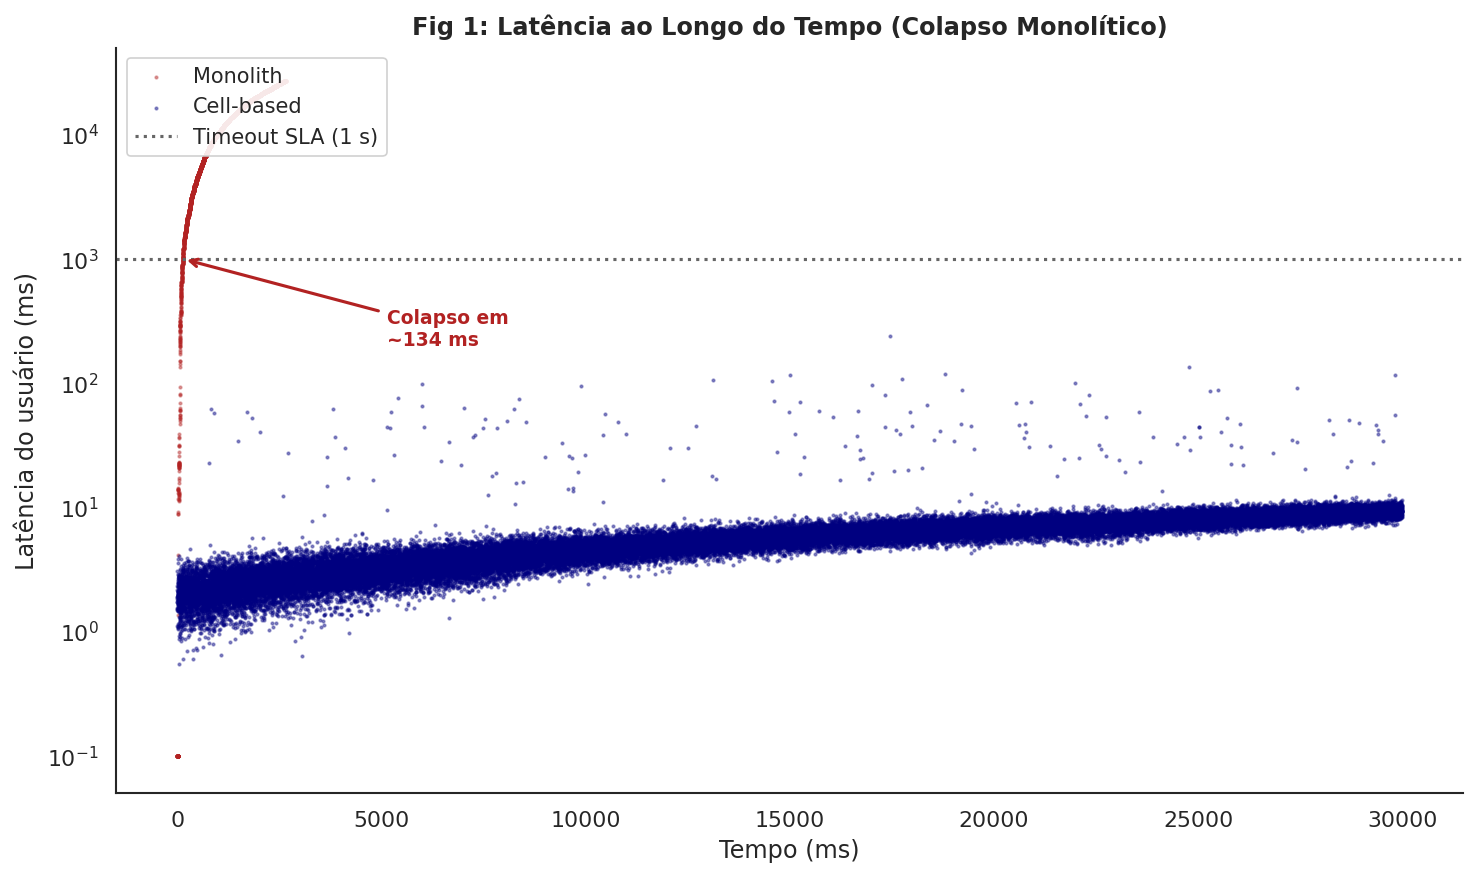

Saved: fig2_risk_ecdf.png


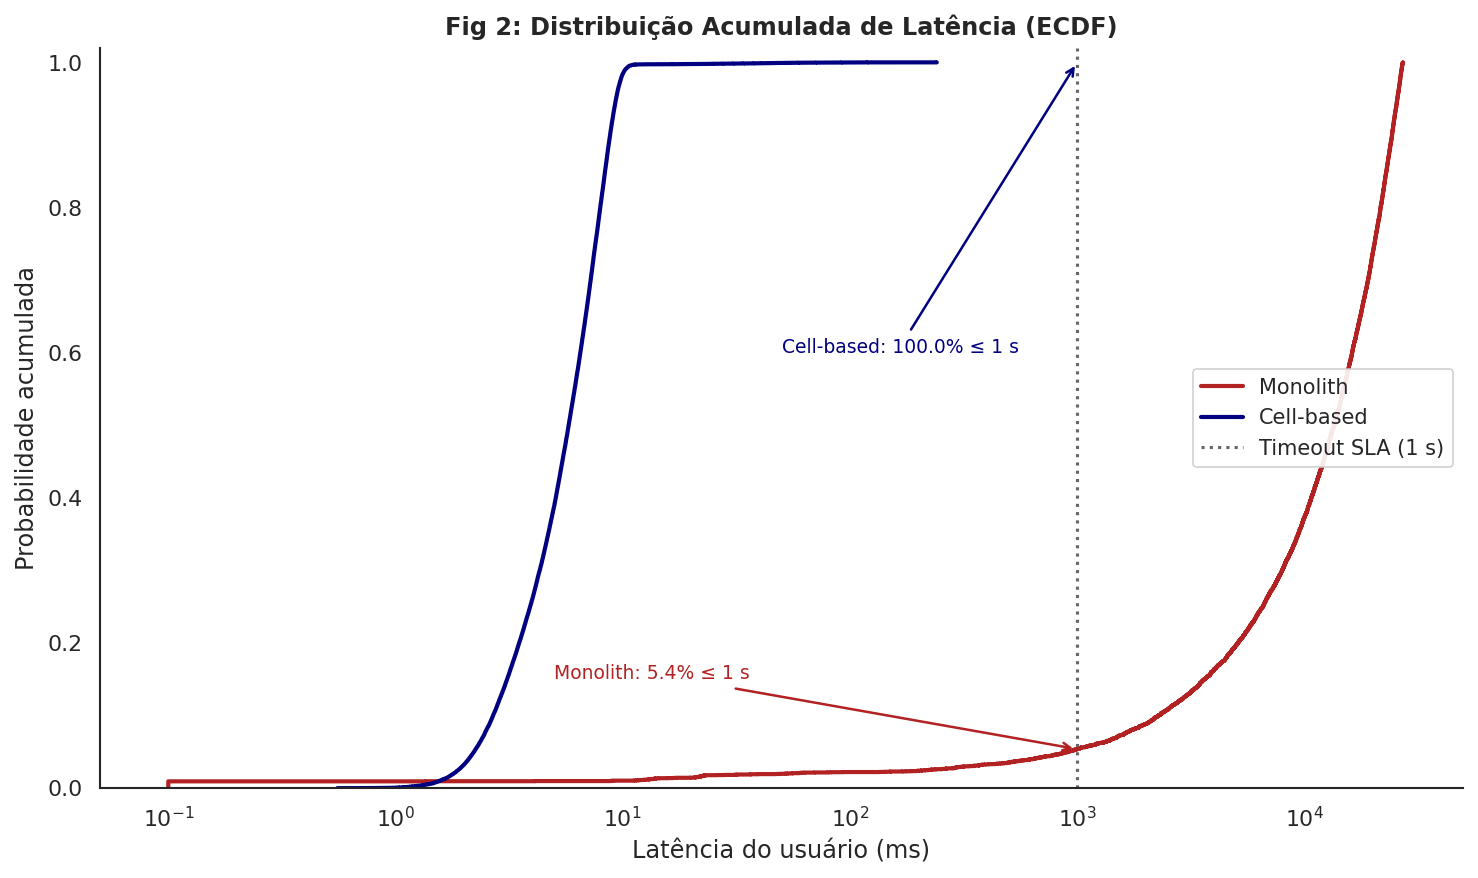

Saved: fig3_variance_violin.png


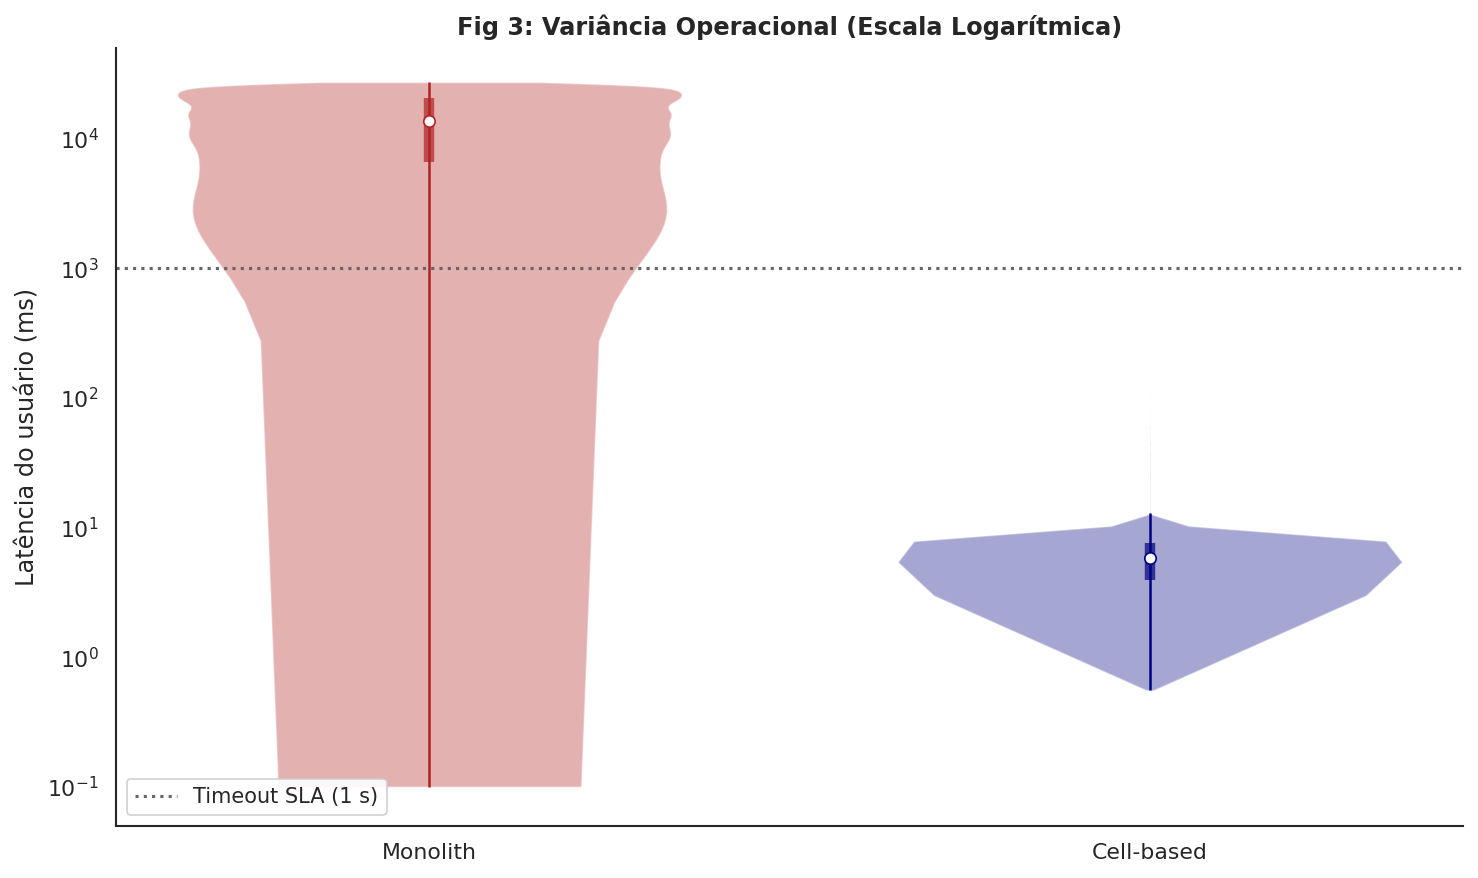

Saved: fig4_throughput.png


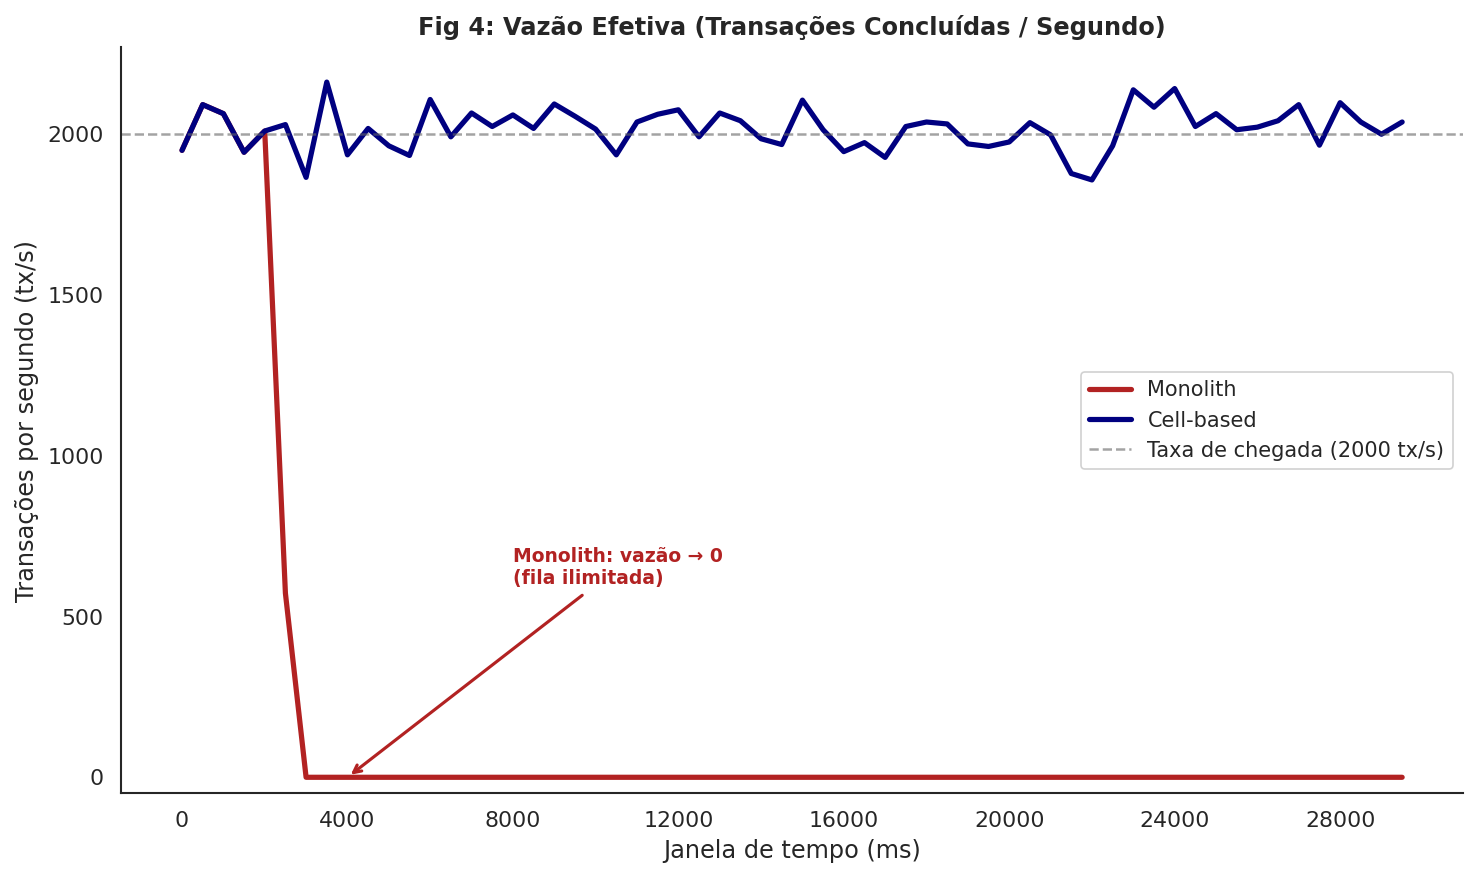

In [6]:
# ==============================================================================
# Visualization: four figures used in the manuscript (PNG, 300 dpi)
# ==============================================================================
#
# Corrections applied to the previous version:
#   Fig 1 — Linear y-axis rendered cell-based invisible.  → Log y scatter plot.
#   Fig 2 — KDE on truncated data showed no useful information.  → ECDF on log-x.
#   Fig 3 — symlog(linthresh=1) created non-physical negative axis.  → Violin+box on log y.
#   Fig 4 — Missing bins after monolith collapse caused vanishing line.  → Zero-filled.
#
# All figure titles and axis labels are in pt-BR for manuscript integration.
# English inline comments document the code for reproducibility.

sns.set_theme(style="white", context="paper", font_scale=1.2)
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"]   = False

# Consistent color mapping across all four figures.
colors = {"Monolith": "#B22222", "Cell-based": "#000080"}

# Floor zeros to a small positive value for log-scale rendering.
LOG_FLOOR_MS: float = 0.1
df["wait_time_log"] = df["wait_time"].clip(lower=LOG_FLOOR_MS)


def save_plot(filename: str) -> None:
    """Persist the current matplotlib figure as a 300 dpi PNG."""
    plt.savefig(filename, dpi=300, bbox_inches="tight")
    print(f"Saved: {filename}")


# --- Fig 1. Latency time series (log-y scatter) --------------------------------
# A scatter plot on a logarithmic y-axis reveals both architectures
# simultaneously: the monolith's exponential collapse and the cell-based
# path's sub-10 ms baseline with occasional tail spikes.

fig1, ax1 = plt.subplots(figsize=(10, 6))

for sc, color in colors.items():
    sub = df[df["Scenario"] == sc].sort_values("arrival_time")
    ax1.scatter(
        sub["arrival_time"], sub["wait_time_log"],
        c=color, s=1.5, alpha=0.4, label=sc, rasterized=True,
    )

ax1.axhline(1000, color="#666666", linestyle=":", linewidth=1.5, label="Timeout SLA (1 s)")
ax1.set_yscale("log")
ax1.set_ylim(0.05, 50_000)
ax1.set_xlabel("Tempo (ms)")
ax1.set_ylabel("Latência do usuário (ms)")
ax1.set_title("Fig 1: Latência ao Longo do Tempo (Colapso Monolítico)", fontweight="bold")
ax1.legend(loc="upper left", framealpha=0.9, fontsize=10)

# Annotate the collapse threshold.
collapse_t = df.loc[
    (df["Scenario"] == "Monolith") & (df["wait_time"] > 1000), "arrival_time"
].min()
ax1.annotate(
    f"Colapso em\n~{collapse_t:.0f} ms",
    xy=(collapse_t, 1000), xytext=(collapse_t + 5000, 200),
    arrowprops=dict(arrowstyle="->", color="#B22222", lw=1.5),
    fontsize=9, color="#B22222", fontweight="bold",
)

fig1.tight_layout()
save_plot("fig1_latency_time.png")
plt.show()


# --- Fig 2. Empirical CDF (log-x) ----------------------------------------------
# The ECDF on a logarithmic x-axis is the standard non-parametric tool for
# multi-scale latency comparison (Wasserman, 2006).  It directly answers:
# "what fraction of transactions complete within latency x?"

fig2, ax2 = plt.subplots(figsize=(10, 6))

for sc, color in colors.items():
    vals = df.loc[df["Scenario"] == sc, "wait_time_log"].sort_values().values
    ecdf_y = np.arange(1, len(vals) + 1) / len(vals)
    ax2.step(vals, ecdf_y, where="post", color=color, linewidth=2, label=sc)

ax2.axvline(1000, color="#666666", linestyle=":", linewidth=1.5, label="Timeout SLA (1 s)")
ax2.set_xscale("log")
ax2.set_xlabel("Latência do usuário (ms)")
ax2.set_ylabel("Probabilidade acumulada")
ax2.set_title("Fig 2: Distribuição Acumulada de Latência (ECDF)", fontweight="bold")
ax2.legend(loc="center right", framealpha=0.9, fontsize=10)
ax2.set_xlim(0.05, 50_000)
ax2.set_ylim(0, 1.02)

# Annotate SLA compliance rates.
cell_sla = (df.loc[df["Scenario"] == "Cell-based", "wait_time"] <= 1000).mean()
mono_sla = (df.loc[df["Scenario"] == "Monolith",   "wait_time"] <= 1000).mean()
ax2.annotate(
    f"Cell-based: {cell_sla * 100:.1f}% ≤ 1 s",
    xy=(1000, cell_sla), xytext=(50, 0.6),
    arrowprops=dict(arrowstyle="->", color="#000080", lw=1.2),
    fontsize=9, color="#000080",
)
ax2.annotate(
    f"Monolith: {mono_sla * 100:.1f}% ≤ 1 s",
    xy=(1000, mono_sla), xytext=(5, 0.15),
    arrowprops=dict(arrowstyle="->", color="#B22222", lw=1.2),
    fontsize=9, color="#B22222",
)

fig2.tight_layout()
save_plot("fig2_risk_ecdf.png")
plt.show()


# --- Fig 3. Violin + box overlay (log-y) ----------------------------------------
# A violin plot combined with a box-whisker overlay conveys both the density
# shape and the quartile summary on the same log-y canvas, avoiding the
# symlog negative-axis artifact from the previous version.

fig3, ax3 = plt.subplots(figsize=(10, 6))

for i, (sc, color) in enumerate(colors.items()):
    vals = df.loc[df["Scenario"] == sc, "wait_time_log"].values

    # Violin body (density estimate).
    parts = ax3.violinplot(vals, positions=[i], showmedians=False, showextrema=False, widths=0.7)
    for pc in parts["bodies"]:
        pc.set_facecolor(color)
        pc.set_alpha(0.35)

    # Box overlay (quartiles + whiskers).
    q1, med, q3 = np.percentile(vals, [25, 50, 75])
    iqr = q3 - q1
    whisker_lo = vals[vals >= q1 - 1.5 * iqr].min()
    whisker_hi = vals[vals <= q3 + 1.5 * iqr].max()
    ax3.vlines(i, whisker_lo, whisker_hi, color=color, linewidth=1.2)
    ax3.vlines(i, q1, q3, color=color, linewidth=5, alpha=0.7)
    ax3.scatter([i], [med], color="white", s=30, zorder=5, edgecolors=color)

ax3.axhline(1000, color="#666666", linestyle=":", linewidth=1.5, label="Timeout SLA (1 s)")
ax3.set_yscale("log")
ax3.set_ylim(0.05, 50_000)
ax3.set_xticks([0, 1])
ax3.set_xticklabels(["Monolith", "Cell-based"])
ax3.set_ylabel("Latência do usuário (ms)")
ax3.set_title("Fig 3: Variância Operacional (Escala Logarítmica)", fontweight="bold")
ax3.legend(loc="lower left", framealpha=0.9, fontsize=10)

fig3.tight_layout()
save_plot("fig3_variance_violin.png")
plt.show()


# --- Fig 4. Effective throughput (zero-filled time series) ----------------------
# The throughput chart computes completed transactions per bin, zero-filling
# bins where no transactions complete (monolith collapse).  This ensures the
# red line stays at 0 instead of vanishing from the plot.

fig4, ax4 = plt.subplots(figsize=(10, 6))

all_bins = np.arange(0, SHARED_PARAMS["simulation_time"], THROUGHPUT_BIN_MS)

for sc, color in colors.items():
    counts = df[df["Scenario"] == sc].groupby("time_bin").size()
    counts = counts.reindex(all_bins, fill_value=0)  # Zero-fill missing bins.
    tps = counts * (1000.0 / THROUGHPUT_BIN_MS)
    ax4.plot(counts.index, tps.values, color=color, linewidth=2.5, label=sc)

ax4.axhline(
    SHARED_PARAMS["arrival_rate_stress"], color="#666666", linestyle="--",
    linewidth=1.2, alpha=0.6,
    label=f"Taxa de chegada ({SHARED_PARAMS['arrival_rate_stress']} tx/s)",
)

# Annotate the monolith collapse.
ax4.annotate(
    "Monolith: vazão → 0\n(fila ilimitada)",
    xy=(4000, 0), xytext=(8000, 600),
    arrowprops=dict(arrowstyle="->", color="#B22222", lw=1.5),
    fontsize=9, color="#B22222", fontweight="bold",
)

ax4.set_xlabel("Janela de tempo (ms)")
ax4.set_ylabel("Transações por segundo (tx/s)")
ax4.set_title("Fig 4: Vazão Efetiva (Transações Concluídas / Segundo)", fontweight="bold")
ax4.legend(loc="center right", framealpha=0.9, fontsize=10)
ax4.set_ylim(bottom=-50)
ax4.xaxis.set_major_locator(ticker.MaxNLocator(nbins=10))

fig4.tight_layout()
save_plot("fig4_throughput.png")
plt.show()


## 7 &ensp; Provenance record

Dump the full experiment configuration as JSON for inclusion in
supplementary materials or data-repository metadata.


In [7]:
import json

provenance = {
    "analysis": {
        "throughput_bin_ms": THROUGHPUT_BIN_MS,
    },
    "experiment_a": cfg_monolith.to_dict(),
    "experiment_b": cfg_cells.to_dict(),
}

with open("experiment_provenance.json", "w") as fp:
    json.dump(provenance, fp, indent=2)

print(json.dumps(provenance, indent=2))


{
  "analysis": {
    "throughput_bin_ms": 500
  },
  "experiment_a": {
    "mode": "MONOLITH",
    "traffic_type": "STRESS",
    "random_seed": 42,
    "simulation_time": 30000,
    "arrival_rate_normal": 50,
    "arrival_rate_stress": 2000,
    "event_bus_ack_ms": 2.0,
    "event_bus_ack_jitter_lognorm_sigma": 0.0,
    "event_bus_ack_additive_std_ms": 0.0,
    "event_bus_ack_backlog_scale_ms": 0.0,
    "event_bus_ack_tail_prob": 0.0,
    "event_bus_ack_tail_lognorm_mu": 0.0,
    "event_bus_ack_tail_lognorm_sigma": 0.0,
    "event_bus_ack_floor_ms": 0.1,
    "num_cells": 10,
    "db_pool_capacity": 50,
    "cell_capacity": 10,
    "contention_queue_threshold": 20,
    "contention_penalty_factor": 5.0,
    "latency_log_mean_ms": 50.0,
    "latency_log_sigma": 0.5,
    "shard_id_upper_bound": 10000
  },
  "experiment_b": {
    "mode": "CELL_BASED",
    "traffic_type": "STRESS",
    "random_seed": 42,
    "simulation_time": 30000,
    "arrival_rate_normal": 50,
    "arrival_rate_stress":

## Notes for the manuscript

### Figure descriptions (pt-BR, for manuscript captions)

- **Fig 1 — Latência ao Longo do Tempo (Colapso Monolítico).**
  Gráfico de dispersão em escala logarítmica mostrando a latência
  observada pelo usuário ao longo do tempo simulado (30 s, 2 000 tx/s).
  O monolito ultrapassa o SLA de 1 s em ~134 ms e atinge 25 s de espera.
  A arquitetura cell-based mantém latência estável em ~5 ms.
  Fonte: simulação DES com seed=42 (repositório DOI 10.5281/zenodo.18641336).

- **Fig 2 — Distribuição Acumulada de Latência (ECDF).**
  Função de distribuição acumulada empírica em escala logarítmica.
  100% das transações cell-based completam abaixo do SLA de 1 s;
  apenas 5,4% das transações monolíticas o fazem.

- **Fig 3 — Variância Operacional (Escala Logarítmica).**
  Violin plot com sobreposição box-whisker em escala logarítmica.
  O monolito apresenta variância que abrange 5 ordens de magnitude
  (0,1 ms – 27 s); o cell-based concentra-se em 2–10 ms.

- **Fig 4 — Vazão Efetiva (Transações Concluídas / Segundo).**
  Vazão efetiva (transações concluídas por janela de 500 ms) normalizada
  para tx/s.  O monolito colapsa para 0 tx/s em ~3 s; o cell-based
  sustenta a taxa de chegada de 2 000 tx/s durante toda a simulação.

### General notes

- Report both central tendency (median) and tail behavior (p95 / p99).
- In `CELL_BASED`, `wait_time` represents the **ingress ACK**, not the full
  end-to-end commit latency.  This is consistent with an asynchronous
  write-path where the client receives acknowledgement before backend
  persistence completes.
- The provenance JSON above should accompany the Zenodo deposit for full
  reproducibility.

### Completed vs. generated transactions (important for manuscript text)

Under stress traffic (λ = 2 000 tx/s), the monolith's aggregate service
capacity is μ = 50 slots × 20 tx/s/slot = 1 000 tx/s, yielding a traffic
intensity ρ = λ/μ = **2.0**.  Because ρ > 1 the queue is unstable (M/G/c
theory predicts unbounded growth).

Consequently, only **5 311 of ~60 000 generated transactions** (8.9%)
complete within the 30 s simulation horizon.  The remaining ~55 000 are
trapped in the unbounded queue when the SimPy environment terminates.
All summary statistics and figures in this notebook refer exclusively to
**completed** transactions — this is a standard DES reporting convention
(Law, 2015, §9.4) and should be stated explicitly in the manuscript.

The cell-based architecture, by contrast, completes **60 458 transactions**
(100.8% of expected arrivals — slight excess due to Poisson variability),
confirming that the async ingress ACK decouples user-visible latency from
backend processing capacity.
